In [1]:
import tensorflow as tf
import numpy as np
import datetime
import json
import gzip
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm_notebook

In [2]:
sess = None

In [7]:
def reset_tf(sess = None, log_device_placement = False):
    if sess:
        sess.close()
    tf.reset_default_graph()
    tf.set_random_seed(0)
    return tf.InteractiveSession(config = tf.ConfigProto(log_device_placement = log_device_placement))

def dump_statistics():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        print('parameters for "%s": %d' % (variable.name, variable_parameters))
        total_parameters += variable_parameters
    print('total parameters: %d' % total_parameters)

In [4]:
class HyperParameters:
    learning_rate = 1e-3
    
    vocab_size = 30000
    num_targets = 2000
    
    dropout_rate = 0.2
    
    context_size = 81
    
    d_embedding_position = 16
    d_embedding_word = 256
    
    d_attention = 256
    d_attention_ff = 512
    
    num_attention_heads = 4
    d_attention_head = d_attention // num_attention_heads
    
    attention_num_layers = 3

    dataset_batch_size = 512
    dataset_num_parallel_calls = 4
    dataset_prefetch_size = 4096
    dataset_shuffle_size = 4096
    
    gradient_clip_norm = 5.0

In [5]:
class EntityLinkingModel:
    def __init__(self, session, hp):
        self._session = session
        self._hp = hp
        
    def _parse_example(self, example_proto):
        parsed = tf.parse_single_example(example_proto, features = {
            'page_id': tf.FixedLenFeature([1], tf.int64),
            'target_id': tf.FixedLenFeature([1], tf.int64),
            'context_word_ids': tf.FixedLenFeature([self._hp.context_size], tf.int64),
            'link_mask': tf.FixedLenFeature([self._hp.context_size], tf.int64) })
        
        return (
            parsed['target_id'],
            parsed['context_word_ids'],
            parsed['link_mask'])

    def _build_data_pipeline(self):
        with tf.variable_scope('dataset'):
            # placeholders
            self._dataset_filenames = tf.placeholder(
                tf.string,
                shape = [None],
                name = 'dataset_filenames')
            self._dataset_limit = tf.placeholder_with_default(
                tf.constant(-1, tf.int64),
                shape = [],
                name = 'dataset_limit')
            self._dataset_shuffle_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_batch_size, tf.int64),
                shape = [],
                name = 'dataset_shuffle_size')
            self._dataset_batch_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_batch_size, tf.int64),
                shape = [],
                name = 'dataset_batch_size')
            self._dataset_prefetch_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_prefetch_size, tf.int64),
                shape = [],
                name = 'dataset_prefetch_size')

            # build dataset
            dataset = tf.data.TFRecordDataset(
                tf.random_shuffle(self._dataset_filenames),
                compression_type='GZIP')
            dataset = dataset.take(self._dataset_limit)
            dataset = dataset.map(
                self._parse_example,
                num_parallel_calls = self._hp.dataset_num_parallel_calls)
            dataset = dataset.shuffle(self._dataset_shuffle_size)
            dataset = dataset.prefetch(self._dataset_prefetch_size)
            dataset = dataset.batch(self._dataset_batch_size)

            # build iterator
            self._dataset_iterator = dataset.make_initializable_iterator()
            (target_labels, context_word_ids, link_mask) = self._dataset_iterator.get_next()
            target_labels = tf.squeeze(target_labels, axis = -1)

            # give key tensors names
            self._context_word_ids = tf.identity(context_word_ids, 'context_word_ids')
            self._target_labels = tf.identity(target_labels, 'target_labels')
            self._link_mask = tf.identity(link_mask, 'link_mask')
            
            # positions
            self._minibatch_size = tf.shape(self._context_word_ids)[0]
            self._minibatch_size = tf.identity(self._minibatch_size, 'minibatch_size')
            p = tf.range(self._hp.context_size, dtype = tf.int64)
            p = tf.tile(p, [self._minibatch_size])
            p = tf.reshape(p, [self._minibatch_size, self._hp.context_size])
            self._context_positions = p
            
    def _attention_layer(self, A, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            projection_weights = tf.get_variable(
                'projection_weights',
                [self._hp.num_attention_heads, self._hp.d_attention, self._hp.d_attention_head])
            output_weights = tf.get_variable(
                'output',
                [self._hp.d_attention, self._hp.d_attention])

            # compute each attention head
            heads = []
            for i in range(self._hp.num_attention_heads):\
                # project queries/keys/values
                Q_proj = tf.tensordot(A, projection_weights[i], axes = 1)
                K_proj = tf.tensordot(A, projection_weights[i], axes = 1)
                V_proj = tf.tensordot(A, projection_weights[i], axes = 1)
                # N.B., hint shapes since tensordot can't infer
                Q_proj.set_shape([None, self._hp.context_size, self._hp.d_attention_head])
                K_proj.set_shape([None, self._hp.context_size, self._hp.d_attention_head])
                V_proj.set_shape([None, self._hp.context_size, self._hp.d_attention_head])

                # compute attention for head
                K_proj_T = tf.transpose(K_proj, perm = [0, 2, 1])
                scaled_logits = tf.matmul(Q_proj, K_proj_T) / tf.sqrt(float(self._hp.d_attention_head))
                head = tf.matmul(tf.nn.softmax(scaled_logits), V_proj)
                heads.append(head)

            # concatenate heads
            result = tf.concat(heads, axis=-1)
            
            # transform by output weights
            result = tf.tensordot(result, output_weights, axes = 1)
            # N.B., hint shape since tensordot can't infer
            result.set_shape([None, self._hp.context_size, self._hp.d_attention])
            
            return result

    def _attention_ff_layer(self, A, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            A = tf.layers.dense(A, self._hp.d_attention_ff, activation=tf.nn.relu, name='fc1')
            A = tf.layers.dense(A, self._hp.d_attention, name='fc2')
            return A
    
    def _attention_full_layer(self, A, scope, reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            # attention (plus residual)
            A = self._attention_layer(A, 'attention', reuse) + A
            
            # post-attention batch norm
            A = tf.layers.batch_normalization(
                A, 
                training=self._training,
                name='attention',
                reuse=reuse)
            
            # post-attention dropout (_after_ batch norm)
            A = tf.layers.dropout(
                A, 
                rate=self._hp.dropout_rate, 
                training=self._training)
            
            # feed-forward (plus residual)
            A = self._attention_ff_layer(A, 'ff', reuse) + A
            
            # post-feed-forward batch norm
            A = tf.layers.batch_normalization(
                A,
                training=self._training,
                name='ff',
                reuse=reuse)
            
            # post-feed-forward dropout
            A = tf.layers.dropout(
                A, 
                rate=self._hp.dropout_rate, 
                training=self._training)
            
            return A
            
    def _build_model(self):
        with tf.variable_scope('model'):
            # placeholder: training flag
            self._training = tf.placeholder(tf.bool, name = 'training')
            
            # embed context words
            word_embeddings = tf.get_variable(
                'word_embeddings', 
                [self._hp.vocab_size, self._hp.d_embedding_word])
            context_words_embedded = tf.nn.embedding_lookup(
                word_embeddings,
                self._context_word_ids)

            # embed context positions
            position_embeddings = tf.get_variable(
                'position_embeddings',
                [self._hp.context_size, self._hp.d_embedding_position],
                dtype=tf.float32)
            context_positions_embedded = tf.nn.embedding_lookup(
                position_embeddings,
                self._context_positions)

            # build full context vector (concat embeddings)
            context_full = tf.concat(
                [context_words_embedded, context_positions_embedded], 
                axis=-1)
            
            # build attention layers
            with tf.variable_scope('attention_with_ff'):
                # build input vector
                context_attention = tf.layers.dense(
                    context_full,
                    self._hp.d_attention,
                    activation=tf.nn.relu,
                    name='input')
                context_attention = tf.layers.batch_normalization(
                    context_attention,
                    training=self._training,
                    name='input')
                context_attention = tf.layers.dropout(
                    context_attention,
                    rate=self._hp.dropout_rate,
                    training=self._training)
                
                layer = context_attention
                for i in range(self._hp.attention_num_layers):
                    layer = self._attention_full_layer(layer, 'layer_%d' % i)

            # average the attention vectors for the link
            # TODO: combine these in a smarter way
            link_mask = tf.cast(self._link_mask, tf.float32)
            link_mask = tf.reshape(link_mask, [-1, self._hp.context_size, 1])
            self._layer0 = layer
            layer *= link_mask
            self._layer1 = layer
            layer = tf.reduce_sum(layer, axis = -2, keep_dims = True)
            layer /= tf.reduce_sum(link_mask, axis = -2, keep_dims = True)
            layer = tf.squeeze(layer, axis = -2)
            self._layer3 = layer
            
            # build final softmax layer
            self._output_logits = tf.layers.dense(
                layer,
                self._hp.num_targets,
                name = 'softmax')

    def _build_training_model(self):
        with tf.variable_scope('train'):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = self._target_labels,
                logits = self._output_logits)
            
            self._total_loss = tf.reduce_sum(losses, name = 'total_loss')
            self._mean_loss = tf.reduce_mean(losses, name = 'mean_loss')
            
            # N.B., tf.nn.softmax here is unnecessary?
            output_labels = tf.argmax(tf.nn.softmax(self._output_logits), axis=-1)
            correct_labels = tf.cast(
                tf.equal(output_labels, self._target_labels), 
                tf.int32)
            self._output_labels = tf.identity(output_labels, name = 'output_labels')
            self._num_correct_labels = tf.reduce_sum(correct_labels, name = 'num_correct_labels')
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                self._global_step = tf.Variable(0, name='global_step', trainable=False)
                self._optimizer = tf.train.AdamOptimizer(learning_rate=self._hp.learning_rate)
                
                # gradient clipping
                gradients, variables = zip(*self._optimizer.compute_gradients(self._mean_loss))
                gradients, _ = tf.clip_by_global_norm(
                    gradients, 
                    self._hp.gradient_clip_norm)
                
                self._train_op = self._optimizer.apply_gradients(
                    zip(gradients, variables),
                    global_step = self._global_step)
#                 self._train_op = self._optimizer.minimize(
#                     self._mean_loss,
#                     global_step=self._global_step)

    
    def build_model(self):
        self._build_data_pipeline()
        self._build_model()
        self._build_training_model()

    def process(self,
                dataset_filenames,
                dataset_limit = -1,
                header = 'results',
                train = False,
                log_file = None):
        # initialize dataset to files
        self._session.run(self._dataset_iterator.initializer, feed_dict={
            self._dataset_filenames: dataset_filenames,
            self._dataset_limit: dataset_limit })

        cum_loss = 0
        cum_num_examples = 0
        cum_correct_examples = 0
        
        start = datetime.datetime.now()
        progress = tqdm_notebook(leave = False, desc = header)

        while True:
            # process a minibatch
            try:
                (_,
                 curr_total_loss, 
                 curr_minibatch_size,
                 curr_num_correct_labels) = self._session.run(
                    (self._train_op if train else (),
                     self._total_loss,
                     self._minibatch_size,
                     self._num_correct_labels),
                    feed_dict = { self._training: train })
            except tf.errors.OutOfRangeError:
                break

            # update stats/progress
            cum_loss += curr_total_loss
            cum_num_examples += curr_minibatch_size
            cum_correct_examples += curr_num_correct_labels
            progress.update(curr_minibatch_size)

        progress.close()
        finish = datetime.datetime.now()

        # print/log output
        message = '%s: time=%s, step=%d, loss=%g, accuracy=%g' % (
            header,
            finish - start,
            tf.train.global_step(sess, self._global_step),
            cum_loss / cum_num_examples,
            cum_correct_examples / cum_num_examples)
        print(message)
        if log_file:
            print(message, file=log_file)
            log_file.flush()

In [6]:
sess = reset_tf(sess)

model = EntityLinkingModel(sess, HyperParameters())
model.build_model()
dump_statistics()

parameters for "model/word_embeddings:0": 7680000
parameters for "model/position_embeddings:0": 1296
parameters for "model/attention_with_ff/input/kernel:0": 69632
parameters for "model/attention_with_ff/input/bias:0": 256
parameters for "model/attention_with_ff/input/gamma:0": 256
parameters for "model/attention_with_ff/input/beta:0": 256
parameters for "model/attention_with_ff/layer_0/attention/projection_weights:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/output:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/gamma:0": 256
parameters for "model/attention_with_ff/layer_0/attention/beta:0": 256
parameters for "model/attention_with_ff/layer_0/ff/fc1/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc1/bias:0": 512
parameters for "model/attention_with_ff/layer_0/ff/fc2/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc2/bias:0": 256
parameters for "model/attention_with_ff/layer_0/ff/gamma:0": 256
parame

In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
def list_files(path):
    return sorted([os.path.join(path, file) for file in os.listdir(path)])

train_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_2.train')
dev_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_2.dev')
test_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_2.test')

In [9]:
with open('../logs/simplewiki/mediawiki_el_softmax_2.log', 'wt') as f:
    for i in range(100):
        model.process(
            train_set,
            header = 'train %d' % i,
            train = True,
            log_file = f)
        model.process(
            dev_set,
            header = 'dev %d' % i,
            train = False,
            log_file = f)

HBox(children=(IntProgress(value=1, bar_style='info', description='train 0', max=1), HTML(value='')))

train 0: time=0:06:08.154327, step=1241, loss=0.772942, accuracy=0.869904


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 0', max=1), HTML(value='')))

dev 0: time=0:00:03.766122, step=1241, loss=0.254948, accuracy=0.9536


HBox(children=(IntProgress(value=1, bar_style='info', description='train 1', max=1), HTML(value='')))

train 1: time=0:06:07.247083, step=2482, loss=0.255689, accuracy=0.948416


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 1', max=1), HTML(value='')))

dev 1: time=0:00:03.400149, step=2482, loss=0.235663, accuracy=0.957


HBox(children=(IntProgress(value=1, bar_style='info', description='train 2', max=1), HTML(value='')))

train 2: time=0:06:07.532584, step=3723, loss=0.212669, accuracy=0.954511


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 2', max=1), HTML(value='')))

dev 2: time=0:00:03.323213, step=3723, loss=0.230071, accuracy=0.9599


HBox(children=(IntProgress(value=1, bar_style='info', description='train 3', max=1), HTML(value='')))

train 3: time=0:06:07.235225, step=4964, loss=0.180741, accuracy=0.959532


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 3', max=1), HTML(value='')))

dev 3: time=0:00:03.393589, step=4964, loss=0.227813, accuracy=0.9598


HBox(children=(IntProgress(value=1, bar_style='info', description='train 4', max=1), HTML(value='')))

train 4: time=0:06:06.745053, step=6205, loss=0.159676, accuracy=0.962976


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 4', max=1), HTML(value='')))

dev 4: time=0:00:03.380296, step=6205, loss=0.22059, accuracy=0.96345


HBox(children=(IntProgress(value=1, bar_style='info', description='train 5', max=1), HTML(value='')))

train 5: time=0:06:06.581870, step=7446, loss=0.141066, accuracy=0.966278


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 5', max=1), HTML(value='')))

dev 5: time=0:00:03.368546, step=7446, loss=0.2493, accuracy=0.9621


HBox(children=(IntProgress(value=1, bar_style='info', description='train 6', max=1), HTML(value='')))

train 6: time=0:06:06.644300, step=8687, loss=0.125298, accuracy=0.969206


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 6', max=1), HTML(value='')))

dev 6: time=0:00:03.369159, step=8687, loss=0.240899, accuracy=0.9637


HBox(children=(IntProgress(value=1, bar_style='info', description='train 7', max=1), HTML(value='')))

train 7: time=0:06:06.610607, step=9928, loss=0.112232, accuracy=0.972009


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 7', max=1), HTML(value='')))

dev 7: time=0:00:03.328160, step=9928, loss=0.240953, accuracy=0.9652


HBox(children=(IntProgress(value=1, bar_style='info', description='train 8', max=1), HTML(value='')))

train 8: time=0:06:06.592126, step=11169, loss=0.098562, accuracy=0.975114


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 8', max=1), HTML(value='')))

dev 8: time=0:00:03.382593, step=11169, loss=0.273252, accuracy=0.9633


HBox(children=(IntProgress(value=1, bar_style='info', description='train 9', max=1), HTML(value='')))

train 9: time=0:06:06.681421, step=12410, loss=0.088165, accuracy=0.977216


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 9', max=1), HTML(value='')))

dev 9: time=0:00:03.372933, step=12410, loss=0.246988, accuracy=0.9646


HBox(children=(IntProgress(value=1, bar_style='info', description='train 10', max=1), HTML(value='')))

train 10: time=0:06:06.578770, step=13651, loss=0.0845449, accuracy=0.977694


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 10', max=1), HTML(value='')))

dev 10: time=0:00:03.304056, step=13651, loss=0.243147, accuracy=0.9642


HBox(children=(IntProgress(value=1, bar_style='info', description='train 11', max=1), HTML(value='')))

train 11: time=0:06:06.709968, step=14892, loss=0.0832473, accuracy=0.978143


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 11', max=1), HTML(value='')))

dev 11: time=0:00:03.324206, step=14892, loss=0.2641, accuracy=0.9636


HBox(children=(IntProgress(value=1, bar_style='info', description='train 12', max=1), HTML(value='')))

train 13: time=0:06:06.540303, step=17374, loss=0.0649493, accuracy=0.982512


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 13', max=1), HTML(value='')))

dev 13: time=0:00:03.379616, step=17374, loss=0.283451, accuracy=0.96625


HBox(children=(IntProgress(value=1, bar_style='info', description='train 14', max=1), HTML(value='')))

train 14: time=0:06:06.525031, step=18615, loss=0.0656903, accuracy=0.982347


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 14', max=1), HTML(value='')))

dev 14: time=0:00:03.365743, step=18615, loss=0.261342, accuracy=0.96465


HBox(children=(IntProgress(value=1, bar_style='info', description='train 15', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train 19: time=0:06:06.564365, step=24820, loss=0.054211, accuracy=0.985085


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 19', max=1), HTML(value='')))

dev 19: time=0:00:03.371990, step=24820, loss=0.298746, accuracy=0.96245


HBox(children=(IntProgress(value=1, bar_style='info', description='train 20', max=1), HTML(value='')))

train 20: time=0:06:06.617061, step=26061, loss=0.0458449, accuracy=0.987243


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 20', max=1), HTML(value='')))

dev 20: time=0:00:03.383083, step=26061, loss=0.299558, accuracy=0.9654


HBox(children=(IntProgress(value=1, bar_style='info', description='train 21', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train 25: time=0:06:06.487968, step=32266, loss=0.0417637, accuracy=0.988333


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 25', max=1), HTML(value='')))

dev 25: time=0:00:03.375482, step=32266, loss=0.302648, accuracy=0.96525


HBox(children=(IntProgress(value=1, bar_style='info', description='train 26', max=1), HTML(value='')))

train 26: time=0:06:06.523824, step=33507, loss=0.0413965, accuracy=0.988357


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 26', max=1), HTML(value='')))

dev 26: time=0:00:03.334459, step=33507, loss=0.337146, accuracy=0.95475


HBox(children=(IntProgress(value=1, bar_style='info', description='train 27', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dev 31: time=0:00:03.377068, step=39712, loss=0.310456, accuracy=0.953


HBox(children=(IntProgress(value=1, bar_style='info', description='train 32', max=1), HTML(value='')))

train 32: time=0:06:06.346118, step=40953, loss=0.033061, accuracy=0.990575


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 32', max=1), HTML(value='')))

dev 32: time=0:00:03.373131, step=40953, loss=0.3354, accuracy=0.96565


HBox(children=(IntProgress(value=1, bar_style='info', description='train 33', max=1), HTML(value='')))

train 33: time=0:06:06.431844, step=42194, loss=0.0352219, accuracy=0.990073


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 33', max=1), HTML(value='')))

dev 33: time=0:00:03.383423, step=42194, loss=0.336286, accuracy=0.9617


HBox(children=(IntProgress(value=1, bar_style='info', description='train 34', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train 38: time=0:06:06.327784, step=48399, loss=0.0291334, accuracy=0.991592


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 38', max=1), HTML(value='')))

dev 38: time=0:00:03.324386, step=48399, loss=0.388188, accuracy=0.96515


HBox(children=(IntProgress(value=1, bar_style='info', description='train 39', max=1), HTML(value='')))

train 39: time=0:06:06.386816, step=49640, loss=0.030772, accuracy=0.991384


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 39', max=1), HTML(value='')))

dev 39: time=0:00:03.358801, step=49640, loss=0.429894, accuracy=0.93505


HBox(children=(IntProgress(value=1, bar_style='info', description='train 40', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train 44: time=0:06:06.313003, step=55845, loss=0.0255687, accuracy=0.992493


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 44', max=1), HTML(value='')))

dev 44: time=0:00:03.377753, step=55845, loss=0.341816, accuracy=0.9654


HBox(children=(IntProgress(value=1, bar_style='info', description='train 45', max=1), HTML(value='')))

train 45: time=0:06:06.369045, step=57086, loss=0.0277581, accuracy=0.991756


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 45', max=1), HTML(value='')))

dev 45: time=0:00:03.343612, step=57086, loss=0.36258, accuracy=0.96535


HBox(children=(IntProgress(value=1, bar_style='info', description='train 46', max=1), HTML(value='')))

train 46: time=0:06:06.252543, step=58327, loss=0.024203, accuracy=0.992891


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 46', max=1), HTML(value='')))

dev 46: time=0:00:03.388954, step=58327, loss=0.350449, accuracy=0.9618


HBox(children=(IntProgress(value=1, bar_style='info', description='train 47', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train 51: time=0:06:06.231547, step=64532, loss=0.0247062, accuracy=0.992705


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 51', max=1), HTML(value='')))

dev 51: time=0:00:03.368133, step=64532, loss=0.30922, accuracy=0.9657


HBox(children=(IntProgress(value=1, bar_style='info', description='train 52', max=1), HTML(value='')))

train 52: time=0:06:06.336791, step=65773, loss=0.0230692, accuracy=0.993101


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 52', max=1), HTML(value='')))

dev 52: time=0:00:03.376301, step=65773, loss=0.367645, accuracy=0.96605


HBox(children=(IntProgress(value=1, bar_style='info', description='train 53', max=1), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [10]:
with open('../logs/simplewiki/mediawiki_el_softmax_2.log', 'rt') as f:
    lines = ''.join([l for l in f])

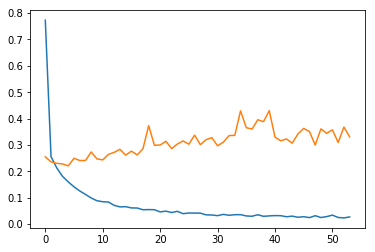

In [14]:
plt.plot([float(v) for v in re.findall(r'train.*loss=(\d+\.\d+)', lines)])
plt.plot([float(v) for v in re.findall(r'dev.*loss=(\d+\.\d+)', lines)])
plt.show()

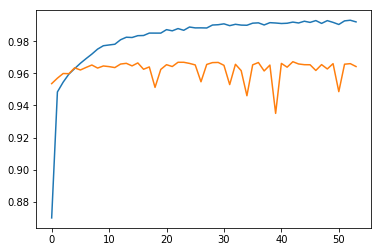

In [16]:
plt.plot([float(v) for v in re.findall(r'train.*accuracy=(\d+\.\d+)', lines)])
plt.plot([float(v) for v in re.findall(r'dev.*accuracy=(\d+\.\d+)', lines)])
plt.show()

In [18]:
builder = tf.saved_model.builder.SavedModelBuilder(
    '../models/simplewiki/el_softmax_2')
builder.add_meta_graph_and_variables(
    sess,
    [tf.saved_model.tag_constants.TRAINING])
builder.add_meta_graph(
    [tf.saved_model.tag_constants.SERVING])
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'../models/simplewiki/el_softmax_2/saved_model.pb'


b'../models/simplewiki/el_softmax_2/saved_model.pb'

# Error Analysis

In [5]:
sess = reset_tf(sess)

In [6]:
_ = tf.saved_model.loader.load(
    sess,
    [tf.saved_model.tag_constants.TRAINING],
    '../models/simplewiki/el_softmax_2')

INFO:tensorflow:Restoring parameters from b'../models/simplewiki/el_softmax_2/variables/variables'


In [8]:
dump_statistics()

parameters for "model/word_embeddings:0": 7680000
parameters for "model/position_embeddings:0": 1296
parameters for "model/attention_with_ff/input/kernel:0": 69632
parameters for "model/attention_with_ff/input/bias:0": 256
parameters for "model/attention_with_ff/input/gamma:0": 256
parameters for "model/attention_with_ff/input/beta:0": 256
parameters for "model/attention_with_ff/layer_0/attention/projection_weights:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/output:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/gamma:0": 256
parameters for "model/attention_with_ff/layer_0/attention/beta:0": 256
parameters for "model/attention_with_ff/layer_0/ff/fc1/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc1/bias:0": 512
parameters for "model/attention_with_ff/layer_0/ff/fc2/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc2/bias:0": 256
parameters for "model/attention_with_ff/layer_0/ff/gamma:0": 256
parame

In [19]:
dataset_iterator = tf.get_default_graph().get_operation_by_name('dataset/MakeIterator')
dataset_filenames = tf.get_default_graph().get_tensor_by_name('dataset/dataset_filenames:0')
training = tf.get_default_graph().get_tensor_by_name('model/Placeholder:0')
context_word_ids = tf.get_default_graph().get_tensor_by_name('dataset/context_word_ids:0')
context_positions = tf.get_default_graph().get_tensor_by_name('dataset/Reshape:0')
link_mask = tf.get_default_graph().get_tensor_by_name('dataset/link_mask:0')
target_labels = tf.get_default_graph().get_tensor_by_name('dataset/target_labels:0')
output_labels = tf.get_default_graph().get_tensor_by_name('train/ArgMax:0')

In [17]:
with open('../data/simplewiki/simplewiki-20171103.el_softmax_2.vocab.txt', 'rt') as f:
    vocab = [w.strip() for w in f]

In [18]:
with open('../data/simplewiki/simplewiki-20171103.el_softmax_2.targets.txt', 'rt') as f:
    targets = [t.strip() for t in f]

In [28]:
def compute_negative_examples(filenames, limit = None):
    # initialize dataset iterator
    sess.run(dataset_iterator, feed_dict = {
        dataset_filenames: filenames,
        training: False })
    
    examples = []
    
    while True:
        # compute minibatch
        try:
            (curr_context_word_ids, curr_target_labels, curr_output_labels, curr_link_mask) = sess.run(
                (context_word_ids, target_labels, output_labels, link_mask),
                feed_dict = { training: False })
        except tf.errors.OutOfRangeError:
                break

        # loop through examples
        for c, t, o, l in zip(curr_context_word_ids, curr_target_labels, curr_output_labels, curr_link_mask):
            # skip accurate inferences
            if t == o:
                continue
                
            # stop if limit reached
            if limit and len(examples) >= limit:
                break
            
            # decode context
            words = []
            link_words = []
            for word_id, link_mask_flag in zip(c, l):
                word = vocab[word_id]
                if link_mask_flag:
                    words.append('_%s_' % word)
                    link_words.append(word)
                else:
                    words.append(word)

            # decode example
            examples.append([
                targets[t], # target label
                targets[o], # output label
                ' '.join(link_words), # link
                ' '.join(words) ]) # context
    
    return examples

In [29]:
examples = compute_negative_examples([
    '../data/simplewiki/simplewiki-20171103.el_softmax_2.dev/examples.0000000000.tfrecords.gz',
    '../data/simplewiki/simplewiki-20171103.el_softmax_2.dev/examples.0000010000.tfrecords.gz'])

In [30]:
examples[0]

['GERMANY',
 'UNITED STATES',
 'german-american',
 '<OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> christian heinrich friedrich peters ( september 19 , <UNK> 18 , 1890 ) was a _german-american_ astronomer , and one of the first to find asteroids . he was born in schleswig-holstein , then part of denmark but later part of germany , and later studied under carl friedrich gauss . he spoke many languages and']

In [31]:
import csv
with open('/tmp/errors.csv', 'wt') as f:
    writer = csv.writer(f)
    writer.writerow(['target', 'output', 'link', 'context'])
    for example in examples:
        writer.writerow(example)

In [ ]:
# with open('../logs/simplewiki/mediawiki_el_softmax_1.multihead.log.old', 'wt') as f:
#     print(lines)

In [ ]:
# with open('../logs/simplewiki/mediawiki_el_softmax_1.multihead.log', 'rt') as f:
#     lines = '\n'.join([l for l in f])
    
# plt.plot([float(v) for v in re.findall(r'train.*loss=(\d+\.\d+)', lines)], label='train')
# plt.plot([float(v) for v in re.findall(r'dev.*loss=(\d+\.\d+)', lines)], label='dev')
# plt.title('loss')
# plt.legend()
# plt.show()
# plt.plot([float(v) for v in re.findall(r'train.*accuracy=(\d+\.\d+)', lines)], label='train')
# plt.plot([float(v) for v in re.findall(r'dev.*accuracy=(\d+\.\d+)', lines)], label='dev')
# plt.title('accuracy')
# plt.legend()
# plt.show()